In [1]:
import os
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from label_flip_revised.utils import open_csv, create_dir
from label_flip_revised.simple_nn_model import SimpleModel
from label_flip_revised.torch_utils import evaluate, train_model

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/label_flip_revised


In [3]:
path_cm = sorted(glob(os.path.join(PATH_ROOT, 'results', 'real_nn', '*.csv')))
print(path_cm)

['/home/lukec/workspace/label_flip_revised/results/real_nn/abalone_nn_poison.csv', '/home/lukec/workspace/label_flip_revised/results/real_nn/australian_nn_poison.csv', '/home/lukec/workspace/label_flip_revised/results/real_nn/banknote_nn_poison.csv', '/home/lukec/workspace/label_flip_revised/results/real_nn/breastcancer_nn_poison.csv', '/home/lukec/workspace/label_flip_revised/results/real_nn/cardiotocography_nn_poison.csv', '/home/lukec/workspace/label_flip_revised/results/real_nn/cmc_nn_poison.csv', '/home/lukec/workspace/label_flip_revised/results/real_nn/htru2_nn_poison.csv', '/home/lukec/workspace/label_flip_revised/results/real_nn/phoneme_nn_poison.csv', '/home/lukec/workspace/label_flip_revised/results/real_nn/ringnorm_nn_poison.csv', '/home/lukec/workspace/label_flip_revised/results/real_nn/texture_nn_poison.csv', '/home/lukec/workspace/label_flip_revised/results/real_nn/yeast_nn_poison.csv']


In [4]:
path_scores = sorted(glob(os.path.join(PATH_ROOT, 'results', 'real', '*_flfa_score.csv')))
print(path_scores)

['/home/lukec/workspace/label_flip_revised/results/real/abalone_subset_std_nn_flfa_score.csv', '/home/lukec/workspace/label_flip_revised/results/real/australian_std_nn_flfa_score.csv', '/home/lukec/workspace/label_flip_revised/results/real/banknote_std_nn_flfa_score.csv', '/home/lukec/workspace/label_flip_revised/results/real/breastcancer_std_nn_flfa_score.csv', '/home/lukec/workspace/label_flip_revised/results/real/cmc_std_nn_flfa_score.csv', '/home/lukec/workspace/label_flip_revised/results/real/htru2_subset_std_nn_flfa_score.csv', '/home/lukec/workspace/label_flip_revised/results/real/phoneme_subset_std_nn_flfa_score.csv', '/home/lukec/workspace/label_flip_revised/results/real/ringnorm_subset_std_nn_flfa_score.csv', '/home/lukec/workspace/label_flip_revised/results/real/texture_subset_std_nn_flfa_score.csv', '/home/lukec/workspace/label_flip_revised/results/real/yeast_subset_std_nn_flfa_score.csv']


In [5]:
DATANAMES = [
    'abalone',
    'australian',
    'banknote',
    'breastcancer',
    'cmc',
    'htru2',
    'phoneme',
    'ringnorm',
    'texture',
    'yeast'
]

DATAFILES = [
    'abalone_subset_std',
    'australian_std',
    'banknote_std',
    'breastcancer_std',
    'cmc_std',
    'htru2_subset_std',
    'phoneme_subset_std',
    'ringnorm_subset_std',
    'texture_subset_std',
    'yeast_subset_std',
]

COL_NAMES = [
    'Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 
    'N2', 'N2 SD', 'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 
    'L1', 'L2', 'L3', 'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 
    'Hubs', 'HubsSD', 'rate'
]

# THRESHOLD = 0.02
FIGSIZE = (8, 6)
FONTSIZE = 14
LAST_N = 6

In [6]:
def save_line_plot(dataname, datafilename, figsize=FIGSIZE, fontsize=FONTSIZE):
    df_cm = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'real_nn', f'{dataname}_nn_poison.csv'))
    rates = [float(Path(d).stem.split('_')[-1]) for d in df_cm['Data'].to_list()]
    df_cm['rate'] = rates
    df_cm = df_cm[df_cm['rate'] <= 0.41]

    df_cm_clean = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'real_cm_clean.csv'))
    df_cm_clean['rate'] = 0.
    df_cm_clean = df_cm_clean[df_cm_clean['Data'] == f'{datafilename}_clean_train.csv']

    df_cm = pd.concat([df_cm_clean, df_cm], ignore_index=True)
    
    # Remove NA
    cols_not_na = df_cm.columns[df_cm.notna().any()].tolist()
    df_cm = df_cm[cols_not_na]

    # Rename columns
    new_names_map = {df_cm.columns[i]:COL_NAMES[i] for i in range(len(COL_NAMES))}
    df_cm = df_cm.rename(new_names_map, axis=1)

    # Sort by rate
    df_cm = df_cm.sort_values(['rate'], ignore_index=True)
    
    # Add scores
    path_score = os.path.join(PATH_ROOT, 'results', 'real', f'{datafilename}_nn_flfa_score.csv')
    df_score = pd.read_csv(path_score)
    df_score = df_score.sort_values(['rate'], ignore_index=True)
    df_cm['train'] = df_score['train']
    df_cm['test'] = df_score['test']

    # Remove columns with minimal change
    # Remove 'Data' column
    c = [
        'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 
        'N2', 'N2 SD', 'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 
        'L1', 'L2', 'L3', 'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 
        'Hubs', 'HubsSD'
    ]

    df_temp = df_cm[c]
    idx = np.argsort(df_temp.std())[-LAST_N:]
    cols_selected = df_temp.columns[idx].tolist()
    cols_selected = np.sort(cols_selected).tolist()
    cols_selected = cols_selected + ['train', 'test', 'rate']
    df_cm = df_cm[cols_selected]

    # Use 'rate' as index, and drop 'rate' column
    df_cm = df_cm.set_index('rate', drop=True)

    # Create pivot table
    s = df_cm.stack()
    s = s.rename_axis(['Rate', 'Measures'])
    df_pivot = s.to_frame()
    df_pivot.columns = ['Value']
    df_pivot = df_pivot.reset_index()

    path_fig_out = os.path.join(PATH_ROOT, 'results', f'{dataname}_falfa_line.pdf', )
    print('Save to:', path_fig_out)

    plt.rcParams["font.size"] = fontsize
    fig, ax = plt.subplots(figsize=figsize)
    sns.set_style(style='ticks')
    line_style = ['Accuracy' if a in ['train', 'test'] else 'C-Measures' for a in df_pivot['Measures']]
    g = sns.lineplot(data=df_pivot, x='Rate', y='Value', hue='Measures', ax=ax, style=line_style, legend='brief')
    plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4)
    ax.set_xlabel('Poisoning Rate')
    ax.set(xlim=[-0.01, 0.41], ylim=[-0.05, 1.05])
    plt.tight_layout(pad=0.8)
    plt.savefig(path_fig_out, dpi=300, bbox_inches='tight')

Save to: /home/lukec/workspace/label_flip_revised/results/abalone_falfa_line.pdf
Save to: /home/lukec/workspace/label_flip_revised/results/australian_falfa_line.pdf
Save to: /home/lukec/workspace/label_flip_revised/results/banknote_falfa_line.pdf
Save to: /home/lukec/workspace/label_flip_revised/results/breastcancer_falfa_line.pdf
Save to: /home/lukec/workspace/label_flip_revised/results/cmc_falfa_line.pdf
Save to: /home/lukec/workspace/label_flip_revised/results/htru2_falfa_line.pdf
Save to: /home/lukec/workspace/label_flip_revised/results/phoneme_falfa_line.pdf
Save to: /home/lukec/workspace/label_flip_revised/results/ringnorm_falfa_line.pdf
Save to: /home/lukec/workspace/label_flip_revised/results/texture_falfa_line.pdf
Save to: /home/lukec/workspace/label_flip_revised/results/yeast_falfa_line.pdf


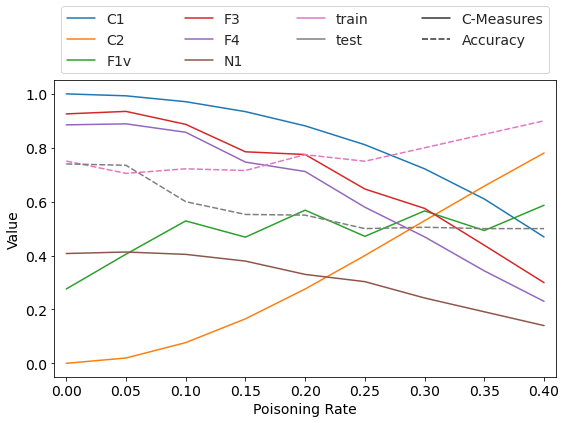

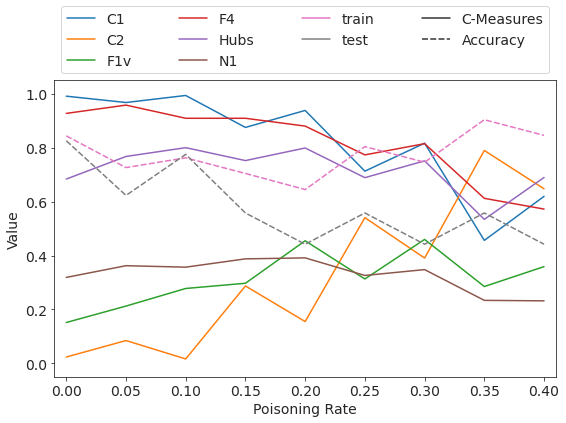

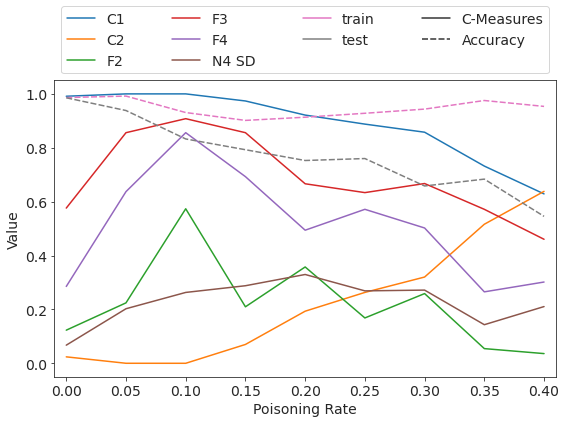

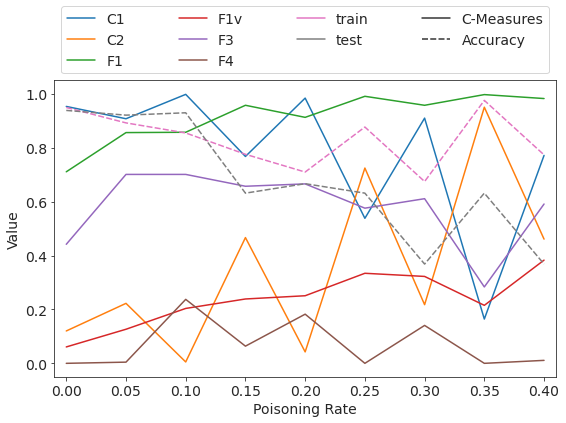

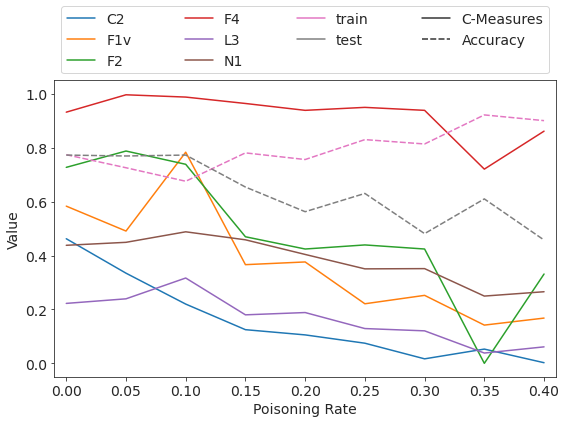

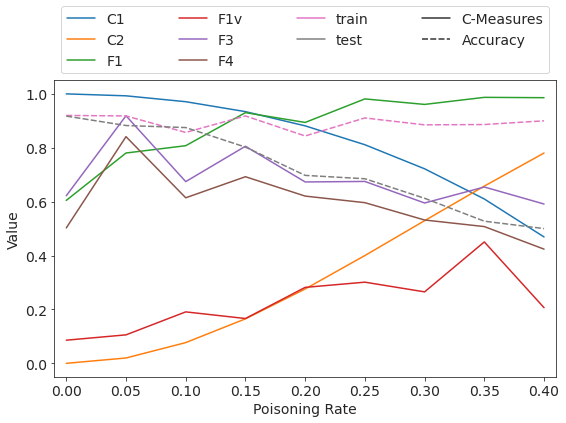

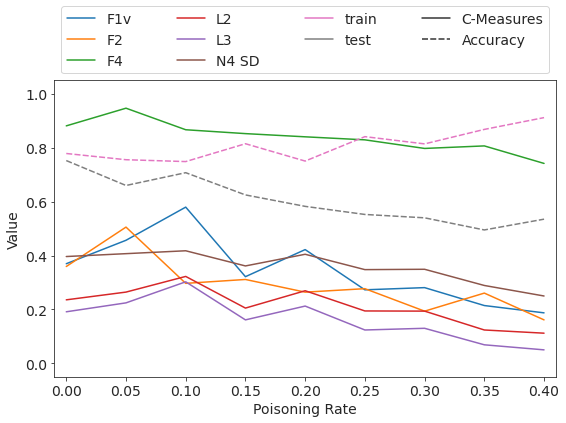

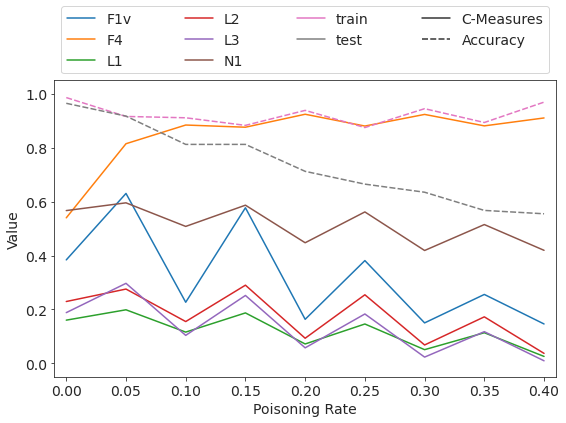

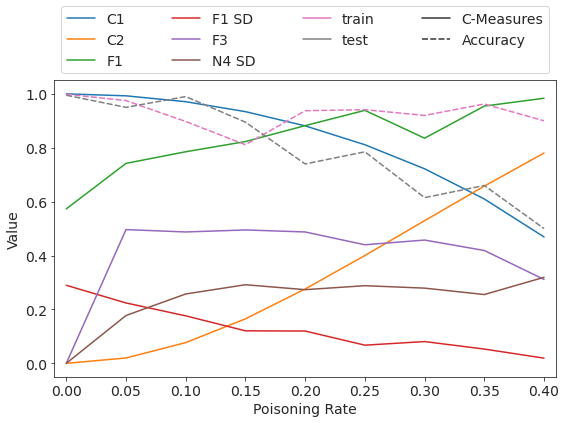

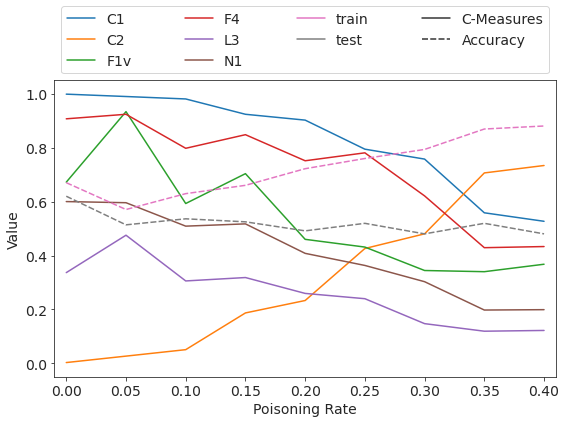

In [7]:
for d, f in zip(DATANAMES, DATAFILES):
    save_line_plot(d, f)